#Introduction: PoliticEs 2022

This shared task aims to extract political ideology information from texts. For this, an author profiling task is proposed. It is focused on the identification of the gender, the profession, and the political spectrum from a binary and multi-class perspective. More info in https://codalab.lisn.upsaclay.fr/competitions/1948

### Enviroment Setup

- Set up working directory
- Installation of libraries

In [1]:

sst_home = './data/'

In [2]:
%pip install transformers 
%pip install tokenizers 

%tensorflow_version 2.x

%pip install pandas
%pip install numpy
%pip install sklearn
%pip install tensorflow
%pip install matplotlib

import tensorflow as tf
print('TensorFlow:', tf.__version__)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%tensorflow_version` not found.


### Auxiliary Functions

- transform_dataframe: Group in the dataframe the different tweets per user to create a single document/record per user.
- group_tweets: It groups in the dataframe the different tweets per user in blocks of tweets that do not exceed a previously established maximum number of tokens.

In [3]:
import random
import pandas as pd

def transform_dataframe(df_):
  df = df_.copy()
  df['tweet'] = df.groupby(['label'])['tweet'].transform(lambda x : ' '.join(x))
  return df[df.columns[1:]].drop_duplicates()

def group_tweets(df, tokenizers, max_tokens = 510, test = False):
  new_data = []
  users = list(df['label'].unique())
  for user in users:
    user_tweets = df[df['label'].isin([user])]
    tweets = user_tweets['tweet'].values
    random.shuffle(tweets)
    num_tokens = 0
    samples = []
    for tweet in tweets:
      max_tokens_tweet = max([len(tokenizer.encode(tweet)) for tokenizer in tokenizers])
      if (num_tokens + max_tokens_tweet > max_tokens):
        tweet_sample = ' '.join(samples)
        if not test:
          new_data.append({'label': user, 'gender': user_tweets['gender'].values[0], 'profession': user_tweets['profession'].values[0], 'ideology_binary': user_tweets['ideology_binary'].values[0], 'ideology_multiclass': user_tweets['ideology_multiclass'].values[0], 'tweet': tweet_sample})
        else:
          new_data.append({'label': user, 'tweet': tweet_sample})
        num_tokens = max_tokens_tweet
        samples = [tweet]
      else:
        num_tokens = num_tokens + max_tokens_tweet
        samples.append(tweet)
    
    if num_tokens > 0:
      tweet_sample = ' '.join(samples)
      if not test:
        new_data.append({'label': user, 'gender': user_tweets['gender'].values[0], 'profession': user_tweets['profession'].values[0], 'ideology_binary': user_tweets['ideology_binary'].values[0], 'ideology_multiclass': user_tweets['ideology_multiclass'].values[0], 'tweet': tweet_sample})
      else:
        new_data.append({'label': user, 'tweet': tweet_sample})
  return new_data

## Training Data Exploration
This section explores the data provided by the organization.

The dataset provided contains tweets from different users selected along Spanish goverment members, Spanish Congress and Senate members, mayors of some important cities in Spain, some autonomous communities presidents, former politicians, collaborators affiliated with political parties and finally, different Spanish news media journalists. Each tweet was labelled with his author’s gender (male and female), profession (politician and journalist) and political spectrum on two axes: binary (left and right) and multiclass (left, moderate left, moderate right and right).

In [4]:
import pandas as pd

df = pd.read_csv(sst_home + 'training-short.csv')
df_grouped = transform_dataframe(df)

The dataset consists of a total of 313 unique users and 120 tweets per user.

In [5]:
df.groupby('label')['tweet'].count().describe()

count      27.000000
mean     1279.407407
std      1528.795586
min        10.000000
25%       244.500000
50%       608.000000
75%      1811.000000
max      5653.000000
Name: tweet, dtype: float64

In [6]:
df.head(5)

,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,@user_0_loscalisdata,male,politician,right,moderate_right,Lamento profundamente el fallecimiento de Davi...
1,@user_0_loscalisdata,male,politician,right,moderate_right,Hace seis años cambiamos de página pero seguim...
2,@user_0_loscalisdata,male,politician,right,moderate_right,Participar en el Foro La Toja es siempre un mo...
3,@user_0_loscalisdata,male,politician,right,moderate_right,Comparto con vosotros el comunicado que acabo ...
4,@user_0_loscalisdata,male,politician,right,moderate_right,"Ha fallecido \n@user\n , un hombre generoso y ..."


In [7]:
df.describe()

,label,gender,profession,ideology_binary,ideology_multiclass,tweet
count,34544,34544,34544,34544,34544,34544
unique,27,2,1,2,3,34538
top,@user_6_loscalisdata,male,politician,left,moderate_right,Sánchez pierde el Socorro Blanco y la legislat...
freq,5653,25837,34544,20008,14536,2


Gender | Male | Female
--- | --- | --- 
Users | 177 | 137 

In [8]:
df_grouped.gender.value_counts()

gender
male      18
female     9
Name: count, dtype: int64

Profession | Politician | Journalist
--- | --- | --- 
Users | 252 | 62 

In [9]:
df_grouped.profession.value_counts()

profession
politician    27
Name: count, dtype: int64

Ideology Binary | Left | Right
--- | --- | --- 
Users | 178 | 136 

In [10]:
df_grouped.ideology_binary.value_counts()

ideology_binary
left     19
right     8
Name: count, dtype: int64

Ideology Multiclass | Left | Moderate Left | Moderate Right | Right
--- | --- | ---  | ---  | --- 
Users | 76 | 102 | 94 | 42

In [11]:
df_grouped.ideology_multiclass.value_counts()

ideology_multiclass
moderate_left     10
left               9
moderate_right     8
Name: count, dtype: int64

Words/Tweet | Mean | Std | Min | Max
--- | --- | ---  | ---  | --- 
 | 41.37 | 11.27 | 1 | 91

In [12]:
df['words'] = [len(x.split()) for x in df['tweet'].tolist()]
df['words'].describe()

count    34544.000000
mean        32.070982
std         12.598857
min          2.000000
25%         21.000000
50%         35.000000
75%         43.000000
max         64.000000
Name: words, dtype: float64

Distribution of words in each tweet

<Axes: >

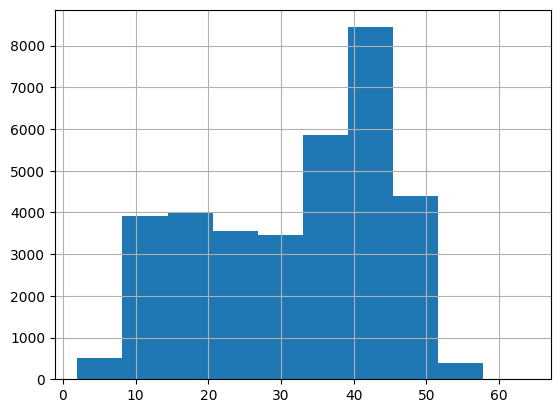

In [13]:
df.tweet.str.split().\
    map(lambda x: len(x)).\
    hist()

In [15]:
import re
import spacy
nlp = spacy.load("es_core_news_sm")

NO_WORDS = ['POLITICAL_PARTY', 'user', '@user', '[POLITICAL_PARTY]']

print("Word list:")
wordList = list()
for i in df.tweet.values:
    for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS) and (not token.is_punct):
          wordList.append(token.text)

print("Gender word list:")
gender_wordList = dict()
for gender in ['male', 'female']:
  new_wl = list()
  for i in df[df['gender'] == gender].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  gender_wordList[gender] = new_wl

print("Profession word list:")
profession_wordList = dict()
for profession in ['journalist', 'politician']:
  new_wl = list()
  for i in df[df['profession'] == profession].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  profession_wordList[profession] = new_wl

print("Ideology word list:")
ideology_wordList = dict()
for ideology in ['left', 'right']:
  new_wl = list()
  for i in df[df['ideology_binary'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_wordList[ideology] = new_wl

print("Ideology multiclass word list:")
ideology_multiclass_wordList = dict()
for ideology in ['left', 'moderate_left', 'moderate_right', 'right']:
  new_wl = list()
  for i in df[df['ideology_multiclass'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_multiclass_wordList[ideology] = new_wl

Lamento profundamente el fallecimiento de David Gistau. A pesar de su juventud era un maestro del periodismo y somos muchos quienes ya echamos en falta todas las brillantes crónicas que aún le quedaban por escribir. Le envío mi abrazo más sincero a su mujer y sus cuatro niños.
Hace seis años cambiamos de página pero seguimos escribiendo el libro de nuestra convivencia. Esta es mi tribuna en 
@user
 con motivo del aniversario de la proclamación de Felipe VI como Rey de España.
Participar en el Foro La Toja es siempre un motivo de orgullo. Enhorabuena a 
@user
 por esta segunda edición y muchas gracias a  
@user
, 
@user
 e Ivan Krastev por el interesante debate que hemos mantenido sobre Europa
Comparto con vosotros el comunicado que acabo de hacer publico.
Ha fallecido 
@user
 , un hombre generoso y patriota. Se ha ido demasiado pronto pero a quienes tuvimos la suerte de conocerle le recordaremos siempre por su coraje y su bondad. Descanse en paz.
Ha sido un placer participar en la conv

KeyboardInterrupt: 

### Total Word Cloud

Wordcloud with the most relevant words from all tweets

In [ ]:
import matplotlib.pyplot as plt
        
# Let us take a look at the most frequently used word in the reviews
from wordcloud import WordCloud
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'magma', 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(wordList))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

### Gender Wordcloud
Wordcloud with the most relevant words by gender

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))

colormaps = ['Blues', 'Purples']
for i, gender in enumerate(['male', 'female']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(gender_wordList[gender]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(gender)

### Profession Wordcloud
Wordcloud with the most relevant words by profession

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Accent', 'hot']
for i, profession in enumerate(['journalist', 'politician']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(profession_wordList[profession]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(profession)

### Binary Ideology Wordcloud
Wordcloud with the most relevant words by binary ideology

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Purples', 'Greens']
for i, ideology in enumerate(['left', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_wordList[ideology]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(ideology)

### Profession Wordcloud
Wordcloud with the most relevant words by multiclass profession

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(20,20))
colormaps = ['Purples', 'Reds', 'Blues', 'Greens']
for i, ideology in enumerate(['left', 'moderate_left', 'moderate_right', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_multiclass_wordList[ideology]))
  plt.subplot(2,2,i + 1)
  plt.imshow(word_cloud, interpolation = "gaussian")
  plt.axis("off")
  plt.title(ideology)

## Custom Dataset Data Exploration
This section contains the data exploration of the dataset developed by our team during the competition.

During our participation in PoliticEs 2022, it was decided to extend the original dataset, collecting tweets from Spanish politicians and journalists posted between January 2021 and February 2022.

As a result, 361,646 different tweets were obtained from a total of 430 unique users. Due to the anonymization of users in the original dataset, it cannot be assured that there are no repeat users. However, since the publication date of the tweets in the dataset provided by the organization is 2020 and that of the tweets collected by our team is 2021 and 2022, it is guaranteed that the new data were not present in the original corpus. An important difference from the original data is that the number of tweets per user is not fixed and varies from user to user.

In [ ]:
import pandas as pd

df = pd.read_csv('drive/My Drive/Colab Notebooks/PoliticES/outputs/ScrappedTweets.csv')
df_group = transform_dataframe(df)

In [ ]:
df

In [ ]:
df.groupby('label')['tweet'].count().describe()

In [ ]:
df.describe()

Gender | Male | Female
--- | --- | --- 
Users | 246 | 184 
Tweets | 227422 | 134224

In [ ]:
df_group.gender.value_counts()

In [ ]:
df.gender.value_counts()

Profession | Politician | Journalist
--- | --- | --- 
Users | 415 | 15
Tweets | 329399 | 32247 

In [ ]:
df_group.profession.value_counts()

In [ ]:
df.profession.value_counts()

Ideology Binary | Left | Female
--- | --- | --- 
Users | 229 | 201 
Tweets | 188661 | 172985

In [ ]:
df_group.ideology_binary.value_counts()

In [ ]:
df.ideology_binary.value_counts()

Ideology Multiclass | Left | Moderate Left | Moderate Right | Right
--- | --- | ---  | ---  | --- 
Users | 160 | 145 | 71 | 54
Tweets | 114751 | 94764 | 79219 | 72921

In [ ]:
df_group.ideology_multiclass.value_counts()

In [ ]:
df.ideology_multiclass.value_counts()

Words/Tweet | Mean | Std | Min | Max
--- | --- | ---  | ---  | --- 
 | 29.72 | 12.28 | 2 | 65

In [ ]:
df['words'] = [len(x.split()) for x in df['tweet'].tolist()]
df['words'].describe()

Distribution of words in each tweet

In [ ]:
df.tweet.str.split().\
    map(lambda x: len(x)).\
    hist()

In [ ]:
import re

NO_WORDS = ['POLITICAL_PARTY', 'user', '@user', '[POLITICAL_PARTY]']

wordList = list()
for i in df.tweet.values:
    for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS) and (not token.is_punct):
          wordList.append(token.text)

gender_wordList = dict()
for gender in ['male', 'female']:
  new_wl = list()
  for i in df[df['gender'] == gender].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  gender_wordList[gender] = new_wl

profession_wordList = dict()
for profession in ['journalist', 'politician']:
  new_wl = list()
  for i in df[df['profession'] == profession].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  profession_wordList[profession] = new_wl

ideology_wordList = dict()
for ideology in ['left', 'right']:
  new_wl = list()
  for i in df[df['ideology_binary'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_wordList[ideology] = new_wl

ideology_multiclass_wordList = dict()
for ideology in ['left', 'moderate_left', 'moderate_right', 'right']:
  new_wl = list()
  for i in df[df['ideology_multiclass'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_multiclass_wordList[ideology] = new_wl

### Total Word Cloud

Wordcloud with the most relevant words from all tweets

In [ ]:
import matplotlib.pyplot as plt
        
# Let us take a look at the most frequently used word in the reviews
from wordcloud import WordCloud
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'magma', 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(wordList))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

### Gender Wordcloud
Wordcloud with the most relevant words by gender

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))

colormaps = ['Blues', 'Purples']
for i, gender in enumerate(['male', 'female']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(gender_wordList[gender]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(gender)

### Profession Wordcloud
Wordcloud with the most relevant words by profession

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Accent', 'hot']
for i, profession in enumerate(['journalist', 'politician']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(profession_wordList[profession]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(profession)

### Binary Ideology Wordcloud
Wordcloud with the most relevant words by binary ideology

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Purples', 'Greens']
for i, ideology in enumerate(['left', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_wordList[ideology]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(ideology)

### Multiclass Ideology Wordcloud
Wordcloud with the most relevant words by multiclass ideology

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(20,20))
colormaps = ['Purples', 'Reds', 'Blues', 'Greens']
for i, ideology in enumerate(['left', 'moderate_left', 'moderate_right', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_multiclass_wordList[ideology]))
  plt.subplot(2,2,i + 1)
  plt.imshow(word_cloud, interpolation = "gaussian")
  plt.axis("off")
  plt.title(ideology)

# Build the model

Proposed system for the author profiling task is based on the fine-tuning of the combination of two pre-trained transformer-based models.

## BETO Set up

The first one, BETO is the first Spanish BERT-based and has demonstrated its performance in a large multitude of different NLP tasks.

In [ ]:
from transformers import BertTokenizer
tokenizer_bert = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

## MarIA Set Up
The second, MarIA, is a recently presented RoBERTa-based model that has been pretrained using a massive corpus of 570GB of clean and deduplicated texts with 135 billion words extracted from the Spanish Web Archive crawled by the National Library of Spain between 2009 and 2019.

In [ ]:
from transformers import RobertaTokenizer
tokenizer_maria = RobertaTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

## Model Creation

User tweets are transformed into tokens that feed BETO and MarIA. From the classification token known as [CLS], each model generates a 768-dimensional vector representing the meaning of the entire sentence. Both vectors are concatenated and the result serves as input to four separate classification blocks, one for each classification task (gender, profession, binary ideology and multiclass ideology). Each classification block is formed by fully connected dense layer with 768 units and 𝑡𝑎𝑛ℎ activation function that directly connects with linear layer with a softmax or sigmoid activation on top, which returns a probability score for each class. Dropout for regularization, with probability of 0.15 to prevent overfitting, is applied after BETO, MarIA and the fully connected dense layers.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras import layers
from transformers import TFBertModel
from transformers import TFRobertaModel

max_len = 512

def create_model():
    ## BERT encoder
    encoder_MARIA = TFRobertaModel.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', from_pt=True)
    encoder_BERT = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', from_pt=True)

    ### INPUTS BERT
    input_ids_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_BERT = encoder_BERT(
        input_ids_BERT, token_type_ids=token_type_ids_BERT, attention_mask=attention_mask_BERT
    )['pooler_output']

    embedding_BERT = layers.Dropout(0.15)(embedding_BERT)

    input_ids_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_MARIA = encoder_MARIA(
        input_ids_MARIA, token_type_ids=token_type_ids_MARIA, attention_mask=attention_mask_MARIA
    )['pooler_output']

    embedding_MARIA = layers.Dropout(0.15)(embedding_MARIA)

    embedding = layers.Concatenate()([embedding_BERT, embedding_MARIA])

    x_gender = layers.Dense(units=768)(embedding)
    x_gender = layers.Activation("tanh")(x_gender)
    x_gender = layers.Dropout(0.15)(x_gender)

    x_ideology = layers.Dense(units=768)(embedding)
    x_ideology = layers.Activation("tanh")(x_ideology)
    x_ideology = layers.Dropout(0.15)(x_ideology)

    x_profession = layers.Dense(units=768)(embedding)
    x_profession = layers.Activation("tanh")(x_profession)
    x_profession = layers.Dropout(0.15)(x_profession)

    x_multi_ideology = layers.Dense(units=768)(embedding)
    x_multi_ideology = layers.Activation("tanh")(x_multi_ideology)
    x_multi_ideology = layers.Dropout(0.15)(x_multi_ideology)


    gender_logits = layers.Dense(1,  activation='sigmoid', name = 'gender_layer')(x_gender)
    profession_logits = layers.Dense(1,  activation='sigmoid', name = 'profession_layer')(x_profession)
    ideology_binary_logits = layers.Dense(1,  activation='sigmoid', name = 'ideology_binary_layer')(x_ideology)
    ideology_multiclass_logits = layers.Dense(4,  activation='softmax', name = 'ideology_multiclass_layer')(x_multi_ideology)
    
    model = keras.Model(
        inputs=[input_ids_BERT, token_type_ids_BERT, attention_mask_BERT, input_ids_MARIA, token_type_ids_MARIA, attention_mask_MARIA],
        outputs=[gender_logits, ideology_binary_logits, profession_logits, ideology_multiclass_logits],
    )

    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss={'gender_layer': 'binary_crossentropy', 'ideology_binary_layer': 'binary_crossentropy', 'profession_layer': 'binary_crossentropy', 'ideology_multiclass_layer': 'sparse_categorical_crossentropy'}, metrics = ['accuracy'])
    return model

In [ ]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

# Load and Prepare Data

The following function transforms the data according to the input expected by the model

In [ ]:
def create_inputs_targets(samples, tokenizer, enc_gender = None, enc_profession = None, enc_ideology_binary = None, enc_ideology_multiclass = None, test = False):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }

    sentences = samples[:, -1]
    if not test:
      y_gender = samples[:, 1]
      y_profession = samples[:, 2]
      y_ideology_binary = samples[:, 3]
      y_ideology_multiclass = samples[:, 4]

    for sentence in sentences:
        input_ids = []
        input_ids = tokenizer.encode(sentence, add_special_tokens=False)
        
        # Keep the tokens of each sentence to improve evaluation
        # Pad truncate
        input_ids = input_ids[:max_len - 2]

        input_ids = [4] + input_ids + [5]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]

    if not test:
      ### GENDER ENCODING
      if not enc_gender:
        enc_gender = preprocessing.LabelEncoder()
        y_gender = enc_gender.fit_transform(y_gender)
      else:
        y_gender = enc_gender.transform(y_gender)

      ### PROFESSION ENCODING
      if not enc_profession:
        enc_profession = preprocessing.LabelEncoder()
        y_profession= enc_profession.fit_transform(y_profession)
      else:
        y_profession= enc_profession.transform(y_profession)

      ### IDEOLOGY_BINARY ENCODING
      if not enc_ideology_binary:
        enc_ideology_binary = preprocessing.LabelEncoder()
        y_ideology_binary = enc_ideology_binary.fit_transform(y_ideology_binary)
      else:
        y_ideology_binary = enc_ideology_binary.transform(y_ideology_binary)

      ### IDEOLOGY MULTICLASS ENCODING
      if not enc_ideology_multiclass:
        enc_ideology_multiclass = preprocessing.LabelEncoder()
        y_ideology_multiclass = enc_ideology_multiclass.fit_transform(y_ideology_multiclass)
      else:
        y_ideology_multiclass = enc_ideology_multiclass.transform(y_ideology_multiclass)

      return x, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass
    else:
      return x

### Generating training data
Due to the limitations of BERT-based models, where the maximum number of tokens is set to 512, it is not possible to concatenate tweets from the same user and serve them as input to our model. Consequently, tweets from the same users are grouped into blocks of maximum 512 tokens. Each block is classified individually using the previously described architecture.


In [ ]:
import pandas as pd

## Load Training dataset. You should change to your own dataset CSV
df = pd.read_csv('drive/My Drive/Colab Notebooks/PoliticES/training.csv')
## Group tweets in blocks max 512 tokens
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))

samples = df.values

x_bert, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_bert)
x_maria, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_maria, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)

Saving proccesed data to avoid repeat the steps next time

In [ ]:
import pickle

X = (x_bert, x_maria, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
with open('drive/My Drive/Colab Notebooks/PoliticES/pickle_data/training-data.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Generating validation data

In [ ]:
import pandas as pd
import numpy as np

## Load Validation dataset. You should change to your own dataset CSV
df = pd.read_csv(sst_home + 'validation.csv')
## Group tweets in blocks max 512 tokens
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))
samples = df.values

x_bert_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_bert, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
x_maria_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_maria, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)

Saving proccesed data to avoid repeat the steps next time

In [ ]:
import pickle

X = (x_bert_test, x_maria_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
with open('drive/My Drive/Colab Notebooks/PoliticES/pickle_data/validation-data.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Training

In [ ]:
bs = 64 if use_tpu else 32
model.fit(
    [x_bert[0], x_bert[1], x_bert[2], x_maria[0], x_maria[1], x_maria[2]],
    {'gender_layer': y_gender, 'ideology_binary_layer': y_ideology_binary, 'profession_layer': y_profession, 'ideology_multiclass_layer': y_ideology_multiclass},
    epochs = 5 ,
    verbose = 1,
    batch_size = bs,
    validation_data = ([x_bert_test[0], x_bert_test[1], x_bert_test[2], x_maria_test[0], x_maria_test[1], x_maria_test[2]],  [y_gender_test,  y_ideology_binary_test, y_profession_test, y_ideology_multiclass_test])
)

### Saving Model

In [ ]:
json_config = model.to_json()
with open('drive/My Drive/Colab Notebooks/PoliticES/PoliticES.json', 'w') as json_file:
    json_file.write(json_config)

model.save_weights('drive/My Drive/Colab Notebooks/PoliticES/PoliticES.h5')

In [ ]:
import pickle
# saving
with open('drive/My Drive/Colab Notebooks/PoliticES/tokenizer.pickle', 'wb') as handle:
    pickle.dump([tokenizer_bert, tokenizer_maria], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('drive/My Drive/Colab Notebooks/PoliticES/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Evaluating Model

Standard measures of accuracy, recall and macro F1 score were applied to evaluate the performance of our model on each classification task. To evaluate the overall performance of the system we employ the macro average F1 score. These metrics are also adopted as the evaluation metrics during PoliticEs task.

In [ ]:
# Loading Test CSV. You should change to your own dataset CSV
df = pd.read_csv(sst_home + 'test.csv')
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))

In [ ]:
from statistics import mode

encoders = {'gender': enc_gender, 'profession': enc_profession, 'ideology_binary': enc_ideology_binary, 'ideology_multiclass': enc_ideology_multiclass}
frequent = lambda x: max(set(x), key = x.count)
df['index'] = [i for i in range(0, len(df))]
tweets_per_user = df.groupby('label')['index'].apply(list).to_dict()

y_pred = model.predict([x_bert_test[0], x_bert_test[1], x_bert_test[2], x_maria_test[0], x_maria_test[1], x_maria_test[2]])
eval_data = list()
for user in tweets_per_user.keys():
  row = dict()
  row['label'] = user
  for i,label in enumerate(['gender', 'ideology_binary', 'profession', 'ideology_multiclass']):
    if label == 'ideology_multiclass':
      y_label = np.argmax(np.mean(y_pred[i][tweets_per_user[user]], axis = 0))
    else:
      y_label = round(np.mean(y_pred[i][tweets_per_user[user]]))

  
    row[label] = y_label
  eval_data.append(row)

evaluation_df = pd.DataFrame(eval_data)
for column in evaluation_df.columns[1:]:
  evaluation_df[column] = encoders[column].inverse_transform(evaluation_df[column])

real_df = df[['label', 'gender', 'ideology_binary', 'profession', 'ideology_multiclass']].drop_duplicates()


In [ ]:
from sklearn.metrics import classification_report
# Validate the result
# As we observed, this task is about four traits: two demographic and two psychographic. Therefore, we are going to
# train different models for each task
# Note that we are doing this because we know the labels on the test set
for label in ['gender', 'profession', 'ideology_binary', 'ideology_multiclass']:

  # Then the results are printed
  print (label)
  print (classification_report (real_df[label], evaluation_df[label], zero_division = 0, digits = 6))

In [ ]:
from sklearn.metrics import f1_score
f1_scores = {}

# Next, we are going to calculate the total result
for label in ['gender', 'profession', 'ideology_binary', 'ideology_multiclass']:
  f1_scores[label] = f1_score(real_df[label], evaluation_df[label], average='macro')

f1_scores = list(f1_scores.values())

print ("Your final F1-score is {f1}".format (f1 = sum(f1_scores) / len(f1_scores)))